In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from __future__ import division
import cvxopt

In [2]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import polynomial_kernel

In [3]:
X = np.array([[1,4],[-3,3],[-2.5, 5], [0,1],[2, 0.5], [1, 2]])
y=np.ones((len(X), 1))
y[3:,0] =-1

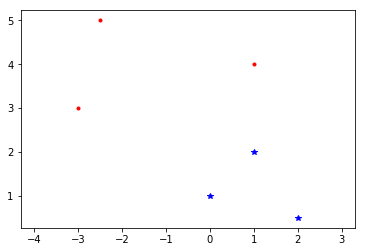

In [4]:
plt.axis('equal')
plt.plot(X[0:3, 0],X[0:3, 1], 'r.', X[3:, 0],X[3:, 1], 'b*')

In [5]:
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

"""
    Solves a quadratic program

        minimize    (1/2)*x'*P*x + q'*x
        subject to  G*x <= h
                    A*x = b.


    """

### Quadratic programming for solving SVM 

In [6]:
m,n = X.shape
X_dash = y * X
H = np.dot(X_dash , X_dash.T) 
P = cvxopt_matrix(H)
q = cvxopt_matrix(-1*np.ones((m,1)))
G = cvxopt_matrix(-np.eye(m))
h = cvxopt_matrix(np.zeros(m))
A = cvxopt_matrix(y.T)
b = cvxopt_matrix(0.0)

In [7]:
#Setting solver parameters (change default to decrease tolerance) 
cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

In [8]:
w = np.zeros((2,))
for i in range(m):
    w += alphas[i]*y[i]*X[i]
print(w)

[-0.25  1.  ]


In [9]:
# Compute w, b
S = (alphas > 1e-4).flatten()
# S is the set of Lagranges multipliers alpha_i which are associated with support vectors
w = np.sum(alphas[S] * y[S] * X[S], axis=0, keepdims=True).T
bias = np.mean(y.reshape((-1,))[S] - np.dot(X[S], w))

In [10]:
print('w', w)
print('b', bias)

('w', array([[-0.25],
       [ 1.  ]]))
('b', -2.7499999997414171)


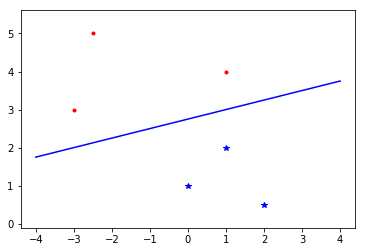

In [11]:
x1 = np.linspace(-4,4)
x2 = (-bias-w[0,0]*x1)/w[1,0]
plt.axis('equal')
plt.plot(X[0:3, 0],X[0:3, 1], 'r.', X[3:, 0],X[3:, 1], 'b*')
plt.plot(x1, x2, 'b-')

### SVM class

In [12]:
class MySVM(object):
    def __init__(self, kernel="linear", C=None, gamma = 1, degree=3, coef0=1):
        self.kernel = kernel
        self.C = C
        if self.C is not None: 
            self.C = float(self.C)
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        #K = np.zeros((n_samples, n_samples))
        if self.kernel == "linear":
            K = X.dot(X.T)
        elif self.kernel == "polynomial":
            K = polynomial_kernel(X, X, degree=self.coef0, gamma=self.gamma, coef0=self.coef0)
        elif self.kernel == "rbf" or self.kernel == "gaussian":
            K = rbf_kernel(X, X, gamma=self.gamma)
        else:
            assert "Kernel %s is not supported!"

        P = cvxopt.matrix(np.multiply(np.outer(y, y), K))
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)), (n_samples*2, n_samples))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)), (n_samples*2, 1))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        alphas = np.array(solution['x'])
        
        alphas_sv = (alphas > 1e-5).reshape((-1,))
        ind = np.arange(len(alphas)).reshape((-1,1))[alphas_sv]
        a = alphas[alphas_sv].reshape((-1,)) # alphas > 0
        sv = X[alphas_sv] # support vectors
        sv_y = y[alphas_sv].reshape((-1,)) # y[i] s.t X[i] is support vector
        #print("%d support vectors out of %d points" % (len(a), n_samples))

        # Intercept
        b = 0
        count = 0
        real_sv = []
        for n in range(len(a)):
            #print(a[n], self.C, a[n] > self.C-1e5)
            if self.C != None and a[n] > self.C-1e-5:
                continue
            else:
                real_sv.append(sv[n])
            b += sv_y[n]
            b -= np.sum(a * sv_y * K[ind[n]].reshape((-1,1))[alphas_sv.reshape((-1,1))])
            count +=1
        b /= count #len(a)
        if self.C:
            self.real_sv = np.array(real_sv)
        print("%d support vectors out of %d points" % (len(real_sv), n_samples))
        self.a = a
        self.b = b
        self.sv_y = sv_y
        self.sv = sv
    
        # Weight vector
        if self.kernel == "linear":

            self.w = np.sum(self.a.reshape((-1,1)) * self.sv_y.reshape((-1,1)) 
                            * self.sv, axis = 0)
        else:
            self.w = None

    
    def predict(self, X):
        return np.sign(self.project(X))

    def project(self, X):
        if self.kernel == 'linear':
            return X.dot(self.w)+self.b
        elif self.kernel == "rbf" or self.kernel =="gaussian":
            K = rbf_kernel(X, self.sv, self.gamma)
        elif self.kernel == "polynomiaal":
            K = polynomial_kernel(X, self.sv, degree=self.coef0, gamma=self.gamma, coef0=self.coef0)
        #print(a*sv_y.shape, ((a*sv_y).T*K).shape)
        return np.sum((self.a*self.sv_y).T*K, axis = 1) + self.b

In [13]:
# Code for generating data and visualizing the decision boundary
import pylab as pl

def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -4; a1 = f(a0, clf.w, clf.b)
    b0 = 4; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.axis("tight")
    pl.show()

def plot_svm_contour(X1_train, X2_train, clf):
    #pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    #pl.plot(X2_train[:,0], X2_train[:,1], "bo")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    #pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1.5, origin='lower')
    pl.contour(X1, X2, Z, [0.0],  cmap=plt.cm.Spectral)
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.scatter(X1_train[:, 0], X1_train[:, 1], c='r', s=10, cmap=plt.cm.Spectral);
    pl.scatter(X2_train[:, 0], X2_train[:, 1], c='b', s=10, cmap=plt.cm.Spectral);
    if clf.C == None:
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=40, c="g")
    else:
        pl.scatter(clf.real_sv[:,0], clf.real_sv[:,1], s=40, c="g")
    pl.axis("tight")
    #pl.show()
    
def plot_svm_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[ :,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[ :,1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model.project(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, np.sign(Z), cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    #print(y)
    plt.scatter(X[:,0], X[:, 1], c=y.reshape((-1,)), s=10, cmap=plt.cm.Spectral)
    pl.scatter(model.sv[:,0], model.sv[:,1], s=40, c="g")

## Non-linearly separable data

In [14]:
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

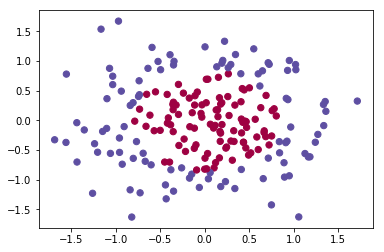

In [15]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "gaussian_quantiles"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "=noisy_moons":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
X = X.T
Y = Y.T.astype(np.float64)
Y[Y==0] = -1

In [16]:
# Train-Test splitting
X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size=0.33, random_state=42)

### Linear kernel SVM

200 support vectors out of 200 points
Accuracy of linear SVM: 54.545455 % (percentage of correctly labelled datapoints)


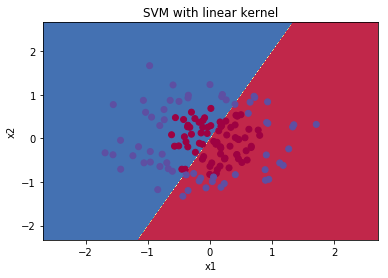

In [17]:
clf = MySVM(kernel="linear", C=None, gamma = 0.05)
clf.fit(X, Y.reshape((-1,)))

# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X_train.T, Y_train.T)
#plt.scatter(clf.sv[:,0], clf.sv[:,1], s=20, c="g")
#plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("SVM with linear kernel")

# Print accuracy
LR_predictions = clf.predict(X_test)
print ('Accuracy of linear SVM: %f ' 
       %float(np.sum(Y_test == LR_predictions.reshape((-1,1)))/float(len(Y_test))*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

### RBF kernel

In [18]:
clf = MySVM(kernel="rbf", C=None, gamma = 0.05)
clf.fit(X, Y.reshape((-1,)))

7 support vectors out of 200 points


Accuracy of RBF kernel SVM: 100.000000 % (percentage of correctly labelled datapoints)


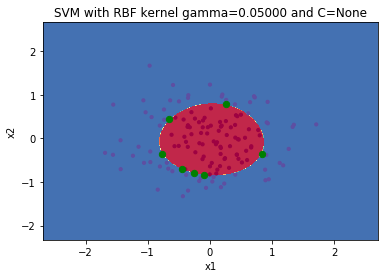

In [19]:
# Plot the decision boundary for RBF SVM
plot_svm_boundary(clf, X_train, Y_train)
plt.title("SVM with RBF kernel gamma=%.5f and C=None" %(clf.gamma))

# Print accuracy
LR_predictions = clf.predict(X_test)
print ('Accuracy of RBF kernel SVM: %f ' 
       %float(np.sum(Y_test == LR_predictions.reshape((-1,1)))/float(len(Y_test))*100) +
       '% ' + "(percentage of correctly labelled datapoints)")


##  Linearly Separable Data with a small overlap

In [20]:
X1, y1, X2, y2 = gen_lin_separable_overlap_data()
X_train, y_train = split_train(X1, y1, X2, y2)
X_test, y_test = split_test(X1, y1, X2, y2)

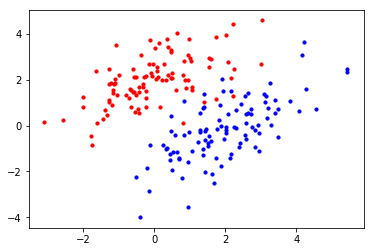

In [21]:
plt.scatter(X1[:,0], X1[:, 1], c='r', s=10, cmap=plt.cm.Spectral);
plt.scatter(X2[:,0], X2[:, 1], c='b', s=10, cmap=plt.cm.Spectral);

### Linear kernel SVM without soft-margin

180 support vectors out of 180 points
4 out of 20 predictions correct


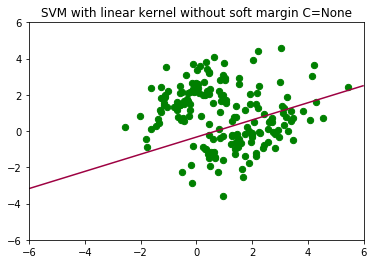

In [22]:
clf1 = MySVM(C=None)
clf1.fit(X_train, y_train)

y_predict = clf1.predict(X_test)
correct = np.sum(y_predict == y_test)
print("%d out of %d predictions correct" % (correct, len(y_predict)))
plt.title("SVM with linear kernel without soft margin C=None" )
plot_svm_contour(X_train[y_train==1], X_train[y_train==-1], clf1)

### Linear kernel SVM with soft margin

3 support vectors out of 180 points
19 out of 20 predictions correct


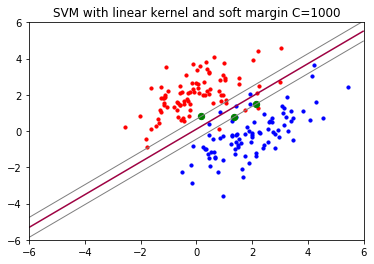

In [23]:
clf2 = MySVM(C=1000)
clf2.fit(X_train, y_train)

y_predict = clf2.predict(X_test)
correct = np.sum(y_predict == y_test)
print("%d out of %d predictions correct" % (correct, len(y_predict)))
plt.title("SVM with linear kernel and soft margin C=%d" %(clf2.C))
plot_svm_contour(X_train[y_train==1], X_train[y_train==-1], clf2)